<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/5_trees_boosting_sol_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación: Trees y Boosting

En aprendizaje de máquinas, la clasificación es el problema de identificar a qué clase (de un grupo finito de clases) una observación nueva pertenece, tomando como base un entrenamiento previo sobre un grupo de observaciones donde sí se conocían sus clases correspondientes. Los algoritmoas basados en árboles están dentro de los más utilizados en aprendizaje de máquinas por el buen rendimiento que alcanzan en la mayoría de las tareas.

In [ ]:
import numpy as np # Biblioteca de álgebra lineal
import pandas as pd # Biblioteca de manejo de conjuntos de datos
import sklearn.tree # Implementación en sklearn del árbol de decisión
import matplotlib.pyplot as plt # Biblioteca de visualización
import sklearn.model_selection # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import sklearn.ensemble # Algoritmos basados en la combinación de estimadores débiles
import sklearn.linear_model # Algoritmos lineales como el Perceptron
import sklearn.preprocessing # Preprocesamiento de características

Utilizaremos un conjunto de datos que relaciona características fisiológicas de pacientes con la presencia de una enfermedad cardiovascular.

<img src="https://cfch.com.sg/wp-content/uploads/2024/11/Minimal-Residual-Disease-MRD_3-1.png" width="1000" height="400"></img>

<img src="https://www.netmeds.com/images/cms/wysiwyg/blog/2019/11/Angina_898X898.jpg" width="500" height="500"></img>

https://medium.com/data-science/heart-disease-uci-diagnosis-prediction-b1943ee835a7


In [ ]:
cardiovascular_diseases = pd.read_csv("https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/cardiovascular_diseases.csv")
cardiovascular_diseases.head()

,age,male,chest_pain_type,resting_blood_pressure,cholesterol,high_fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_by_exercise,slope_st_by_excercise_peak,number_of_vessels_colored_by_flouroscopy,thalassemia,cardiovascular_disease
0,45,0,typical_angina,138,236,0,0,152,1,0.2,0,0,fixed_defect,1
1,61,1,typical_angina,120,260,0,1,140,1,3.6,0,1,reversable_defect,0
2,44,0,non_anginal_pain,108,141,0,1,175,0,0.6,0,0,fixed_defect,1
3,77,1,typical_angina,125,304,0,0,162,1,0.0,-1,3,fixed_defect,0
4,35,1,typical_angina,126,282,0,0,156,1,0.0,-1,0,reversable_defect,0


Separamos nuestro conjunto de datos en sus características y su etiqueta. A las características se les realiza una transformación One-Hot en donde las características discretas con un número `i` de categorías se les transforma en `i` características nuevas binarias. Esto es necesario, porque los algoritmos necesitan una representación estrictamente numérica de las características y este método no les asigna un número entero porque estas variables no tienen un orden ni valor numérico real. Por ejemplo si se tiene una característica con los valores

<img src="https://www.brainstobytes.com/content/images/2020/01/PokeData.png"></img>

y se le transforma utilizando One-Hot Encoding, se separan los tipos

<img src="https://www.brainstobytes.com/content/images/2020/01/PokeData2.png"></img>

Asi se ven las características discretas previas a la transformación.

In [ ]:
cardiovascular_diseases[["chest_pain_type","thalassemia"]].head()

,chest_pain_type,thalassemia
0,typical_angina,fixed_defect
1,typical_angina,reversable_defect
2,non_anginal_pain,fixed_defect
3,typical_angina,fixed_defect
4,typical_angina,reversable_defect


In [ ]:
cardiovascular_diseases["chest_pain_type"].unique()

array(['typical_angina', 'non_anginal_pain', 'asymptomatic',
       'atypical_angina'], dtype=object)

In [ ]:
cardiovascular_diseases["thalassemia"].unique()

array(['fixed_defect', 'reversable_defect', 'normal'], dtype=object)

Con la función `pandas.get_dummies()` realizamos la transformación.

In [ ]:
cardiovascular_diseases_features = pd.get_dummies(
    cardiovascular_diseases.iloc[:,:-1]
)
cardiovascular_diseases_label = cardiovascular_diseases.cardiovascular_disease
cardiovascular_diseases_features.iloc[:,-7:].head()

,chest_pain_type_asymptomatic,chest_pain_type_atypical_angina,chest_pain_type_non_anginal_pain,chest_pain_type_typical_angina,thalassemia_fixed_defect,thalassemia_normal,thalassemia_reversable_defect
0,False,False,False,True,True,False,False
1,False,False,False,True,False,False,True
2,False,False,True,False,True,False,False
3,False,False,False,True,True,False,False
4,False,False,False,True,False,False,True


Separamos nuestro conjunto de datos en un subconjunto de entrenamiento y prueba.

In [ ]:
(cardiovascular_diseases_features_train, cardiovascular_diseases_features_test,
 cardiovascular_diseases_label_train, cardiovascular_diseases_label_test) = sklearn.model_selection.train_test_split(
    cardiovascular_diseases_features,
    cardiovascular_diseases_label,
    test_size=0.33,
    random_state=11)

## Decision Tree



En sklearn la implementación del árbol de decisión está en `sklearn.tree.DecisionTreeClassifier`

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
    max_depth=3, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
    random_state = 11
    )
tree.fit( # Ajustamos nuestro árbol de decisión.
    cardiovascular_diseases_features_train,
    cardiovascular_diseases_label_train
)

DecisionTreeClassifier(max_depth=3, random_state=11)

Verificamos el rendimiento de nuestro árbol de decisión sobre nuestro subconjunto de prueba.

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    tree.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65        47
           1       0.69      0.68      0.69        53

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.67      0.67      0.67       100



Una de las ventajas más importantes de los árboles de decisión es la transparencia y explicabilidad del proceso de predicción. Podemos conocer claramente todas las decisiones tomadas por el clasificador y visualizarla en un árbol de decisión.

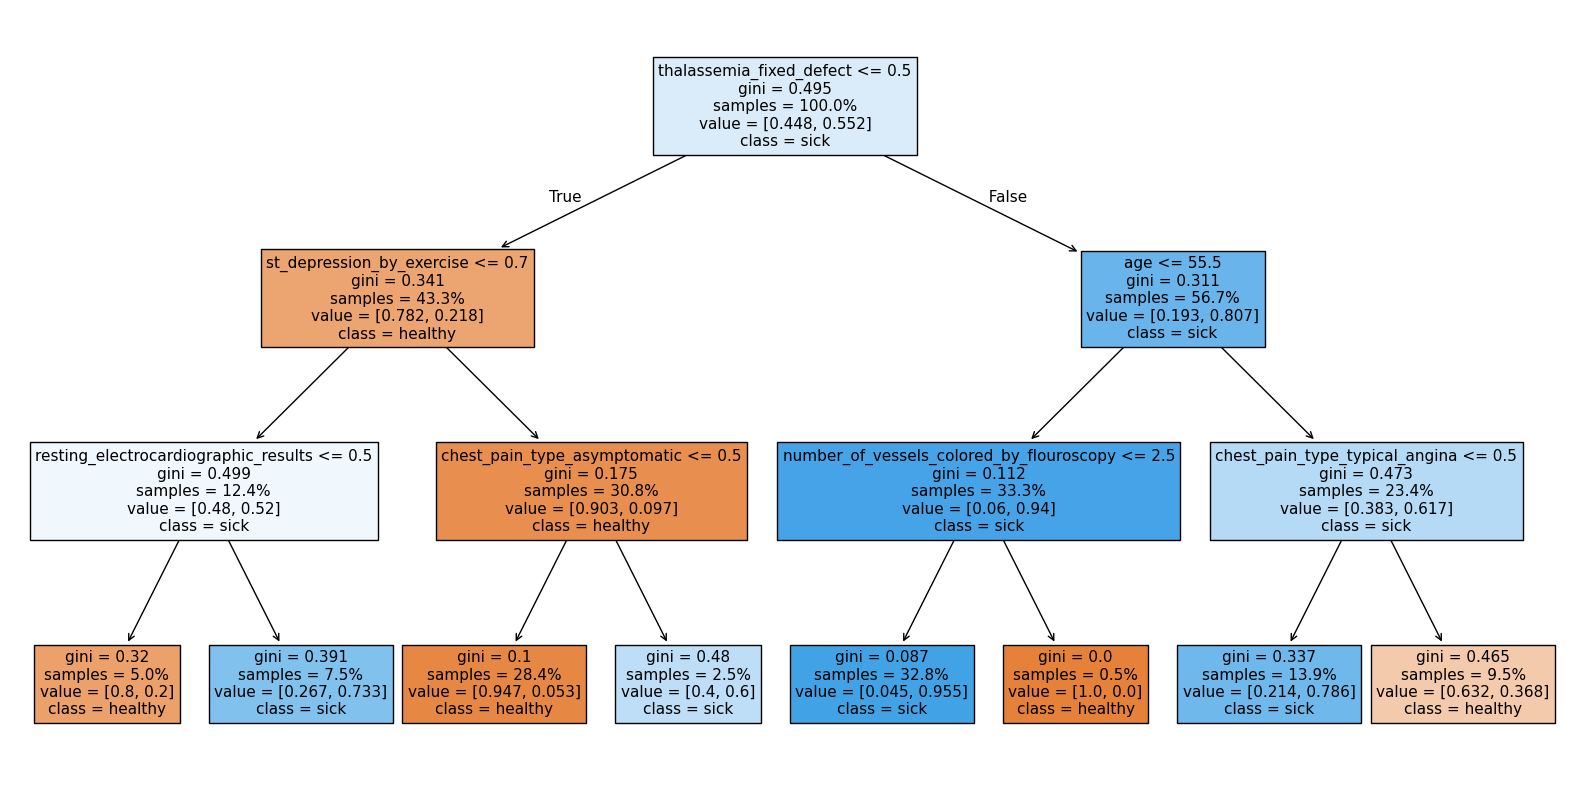

In [ ]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = cardiovascular_diseases_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

### Actividad 1

Uno de los hiperparámetros de los árboles de decisión es la profundidad del mismo. Evalúa cómo se comporta su rendimiento al cambiar la profundidad del árbol.

In [ ]:
import sklearn.model_selection
depths = range(1,10)
performances = []
for depth in depths:
  current_tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
    max_depth=depth, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
    random_state = 11
    )
  roc_auc = sklearn.model_selection.cross_val_score(
      current_tree,
      cardiovascular_diseases_features,
      cardiovascular_diseases_label,
      scoring="roc_auc"
  ).mean()
  performances.append(roc_auc)

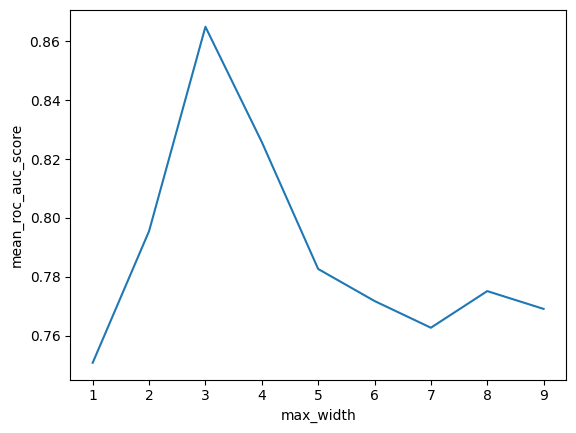

In [ ]:
plt.plot(
    depths,
    performances
)
plt.xlabel("max_width")
plt.ylabel("mean_roc_auc_score")
plt.show()

#### ¿Qué es la curva ROC?

La explicación de esta sección está orientada a entender que es la curva ROC, los resultados no apuntan directamente a explicar el orden lógico y rápido de utilizarla, dado que dicho resultado es el de arriba.

Imagen curva ROC:

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20230410164437/AUC-ROC-Curve.webp"></img>

*   TPR = True Positive Rate
*   FPR = False Positive Rate
*   AUC = Area under the Curve

La curva ROC, corresponde a la curva generada a partir de los ratios de verdaderos y falsos positivos. Es una curva que permite discernir los puntos de "operación" de un clasificador, en donde cada punto de esta curva muestra el comportamiento del clasificador al aumentar o disminuir el umbral de decisión de predecir una clase positiva (o negativa dependiendo del sentido). Esto no lo hemos implementado en clases, pero uno puede retornar como salida la probabilidad de la predicción en vez de la clasificación, permitiendo el investigadxr determine que umbral utilizar. Esto abre la posibilidad de entrenar clasificadores que tengan umbrales de clasificación "conservadores", que solo clasifiquen la clase positiva en los casos que estén extremadamente seguros con una muy alta probabilidad ej sobre 0.8 (disminuyendo la tasa falsos positivos), o viceversa, que tiendan a clasificar positivamente en umbrales menores a 0.5 (tiendan a tener una tasa falsos positivos mayor). Esto es interesante en contextos donde la clasificación puede ser muy costosa, como la vida de una persona, o en el caso inverso, donde no clasificar sea muy caro y en consecuencia me convenga tener más falsos positivos ej: Algunos exámenes que no son tan concluyentes, pero aseguran que si son negativos haya muy baja chance de ser de la clase positiva (prueba antígenos PCR).

La tendencia de la curva permite además establecer el comportamiento del clasificador, en donde la siguiente imagen ejemplifica ello:


<img src="https://glassboxmedicine.com/wp-content/uploads/2019/02/roc-curve-v2.png"></img>

Un clasificador perfecto, tendrá una curva con un ángulo de 90 grados, en donde existe la posibilidad de tener un 100% de verdaderos positivos sin la necesidad de aumentar los falsos. En la práctica, esto no sucede (a menos de que haya sobre ajuste), pero uno espera que la curva de su clasificador tienda a dicha región.


In [ ]:
# Ejemplo construccion curva ROC, con nuestro decision tree

# Se inicializa la clase
tree = sklearn.tree.DecisionTreeClassifier(max_depth=3, random_state = 11)
# Se entrena el clasificador
tree.fit(cardiovascular_diseases_features_train, cardiovascular_diseases_label_train)

DecisionTreeClassifier(max_depth=3, random_state=11)

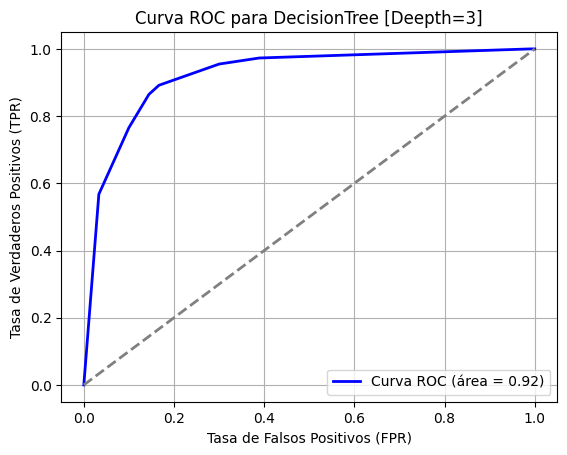

In [ ]:
from sklearn.metrics import roc_curve, auc

# Esto nos retorna la probabilidad de cada clase de nuestro clasificador,
# como este problema posee dos, retorna dos valores para cada una de las filas
# de nuestro conjunto de datos. La curva ROC solo utiliza informacion de la
# clasificacion positiva, por ende solo utilizaremos esos valores.
y_proba = tree.predict_proba(cardiovascular_diseases_features_train)[:, 1]

# Esta funcion calculo los valores de FPR y TPR, variando tresholds de forma automatica
fpr, tpr, thresholds = roc_curve(cardiovascular_diseases_label_train, y_proba)

# Calculamos el AUC (Área bajo la curva)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para DecisionTree [Deepth=3]')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Acá la función "roc_curve" de sklearn facilita el trabajo, en donde esta genera los valores de TPR y FPR de forma automática, siendo "thresholds" los valores que utilizo como umbral de selección para estimar los valores previos. Veamos que hay en tresholds:

In [ ]:
thresholds

array([       inf, 0.95454545, 0.78571429, 0.73333333, 0.6       ,
       0.36842105, 0.2       , 0.05263158, 0.        ])

En otras palabras, verifico como funciona nuestro clasificador si tiene como umbral de decisión "inf" (infinito), "0.95", "0.78", etc. Básicamente, calculo los FPR y TPR considerando que la clase positiva necesita tener una probabilidad mayor a "inf", "0.95", etc.

Finalmente, veamos cómo se ven las curvas ROC de los distintos DecisionTree con distintas profundidades:



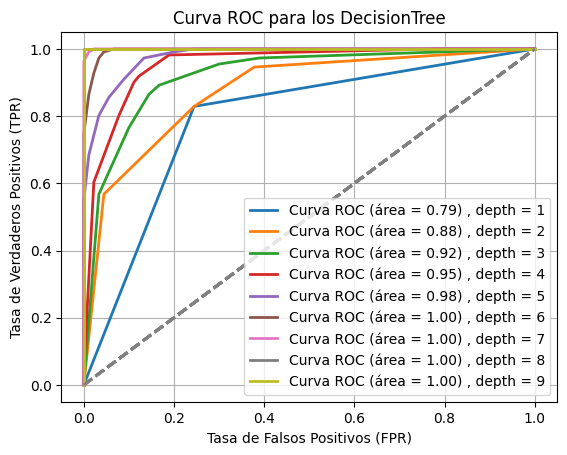

In [ ]:
# Profundidades que utilizaremos
depths = range(1,10)

# Grafico
plt.figure()

# Recorremos las profundidades
for depth in depths:
  # Inicializamos la clase con la profundidad especifica
  current_tree = sklearn.tree.DecisionTreeClassifier(
  max_depth=depth,
  random_state = 11)

  # Entrenamos el arbol
  current_tree.fit(cardiovascular_diseases_features_train, cardiovascular_diseases_label_train)

  # Obtenemos el vector de probabilidades
  y_proba = current_tree.predict_proba(cardiovascular_diseases_features_train)[:, 1]

  # Calculamos los FPR y TPR, de nuestro arbol
  fpr, tpr, thresholds = roc_curve(cardiovascular_diseases_label_train, y_proba)

  # Calculamos el AUC (Área bajo la curva)
  roc_auc = auc(fpr, tpr)

  # Graficamos la curva ROC
  plt.plot(fpr, tpr, lw=2, label=f'Curva ROC (área = {roc_auc:.2f}) , depth = {depth}')
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea aleatoria


# Grafico general
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para los DecisionTree')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Estos resultados no son exactamente a los de arriba debido a que fueron entrenados y evaluados únicamente con el conjunto de entrenamiento (sin cross validation). Debido a esto, existen valores de sobre ajuste, en donde claramente los arboles con profundidad 6 en adelante son perfectos. Evaluar los clasificadores 3, 4 y 5 en el conjunto test, nos dará la respuesta de cual es mejor.

In [ ]:
current_tree = sklearn.tree.DecisionTreeClassifier(max_depth=3, random_state = 11)
current_tree.fit(cardiovascular_diseases_features_train, cardiovascular_diseases_label_train)

print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    current_tree.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65        47
           1       0.69      0.68      0.69        53

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.67      0.67      0.67       100



In [ ]:
current_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4, random_state = 11)
current_tree.fit(cardiovascular_diseases_features_train, cardiovascular_diseases_label_train)

print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    current_tree.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.60      0.57      0.59        47
           1       0.64      0.66      0.65        53

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



In [ ]:
current_tree = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state = 11)
current_tree.fit(cardiovascular_diseases_features_train, cardiovascular_diseases_label_train)

print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    current_tree.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64        47
           1       0.68      0.60      0.64        53

    accuracy                           0.64       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.64      0.64      0.64       100



Como se observa, el caso de depth=3 posee las mejores métricas.

En la práctica, si uno estima el promedio de cross validation de la métrica AUC, estará evaluando cual es el comportamiento de clasificación positiva para distintas variaciones del conjunto de test y entrenamiento. Por ello, permite establecer la robusteza del modelo, en donde un valor mayor representa una mejor generalización de clasificación de la clase positiva. En otras palabras, el comportamiento de clasificación se mantiene alto, independiente del conjunto test y train.


## Random Forest

En Random Forest, cada árbol en el conjunto está construido desde una muestra del conjunto de entrenamiento.

In [ ]:
random_forest = sklearn.ensemble.RandomForestClassifier(random_state = 11) # Instanciamos Random Forest.
random_forest.fit( # Ajustamos nuestro modelo.
    cardiovascular_diseases_features_train,
    cardiovascular_diseases_label_train
)

RandomForestClassifier(random_state=11)

Evaluamos el rendimiento de nuestro modelo y evidenciamos que es significativamente mayor que un árbol de decisión único.

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    random_forest.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        47
           1       0.80      0.83      0.81        53

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



Una de la información de inferencia que podemos extraer desde nuesto modelo entrenado es la lista de importancia de características, con la cual podemos conocer qué características son más importantes para el modelo.

In [ ]:
feature_importance_list = pd.DataFrame(
    zip(cardiovascular_diseases.columns,
        random_forest.feature_importances_), # En este atributo está almacenada la lista de importancia de características.
    columns=["feature","importance"])
feature_importance_list.sort_values("importance",ascending=False)

,feature,importance
8,exercise_induced_angina,0.120717
6,resting_electrocardiographic_results,0.118239
0,age,0.093151
10,slope_st_by_excercise_peak,0.072617
3,resting_blood_pressure,0.072449
2,chest_pain_type,0.065066
9,st_depression_by_exercise,0.040547
7,maximum_heart_rate_achieved,0.032626
1,male,0.024686
5,high_fasting_blood_sugar,0.023107


### Actividad 2

Random Forest es un conjunto de árboles de decisión independientes. Extrae uno de los árboles de decisión del conjunto y visualiza el grafo de decisión. Visita la documentación de Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
random_tree = random_forest.estimators_[-1]

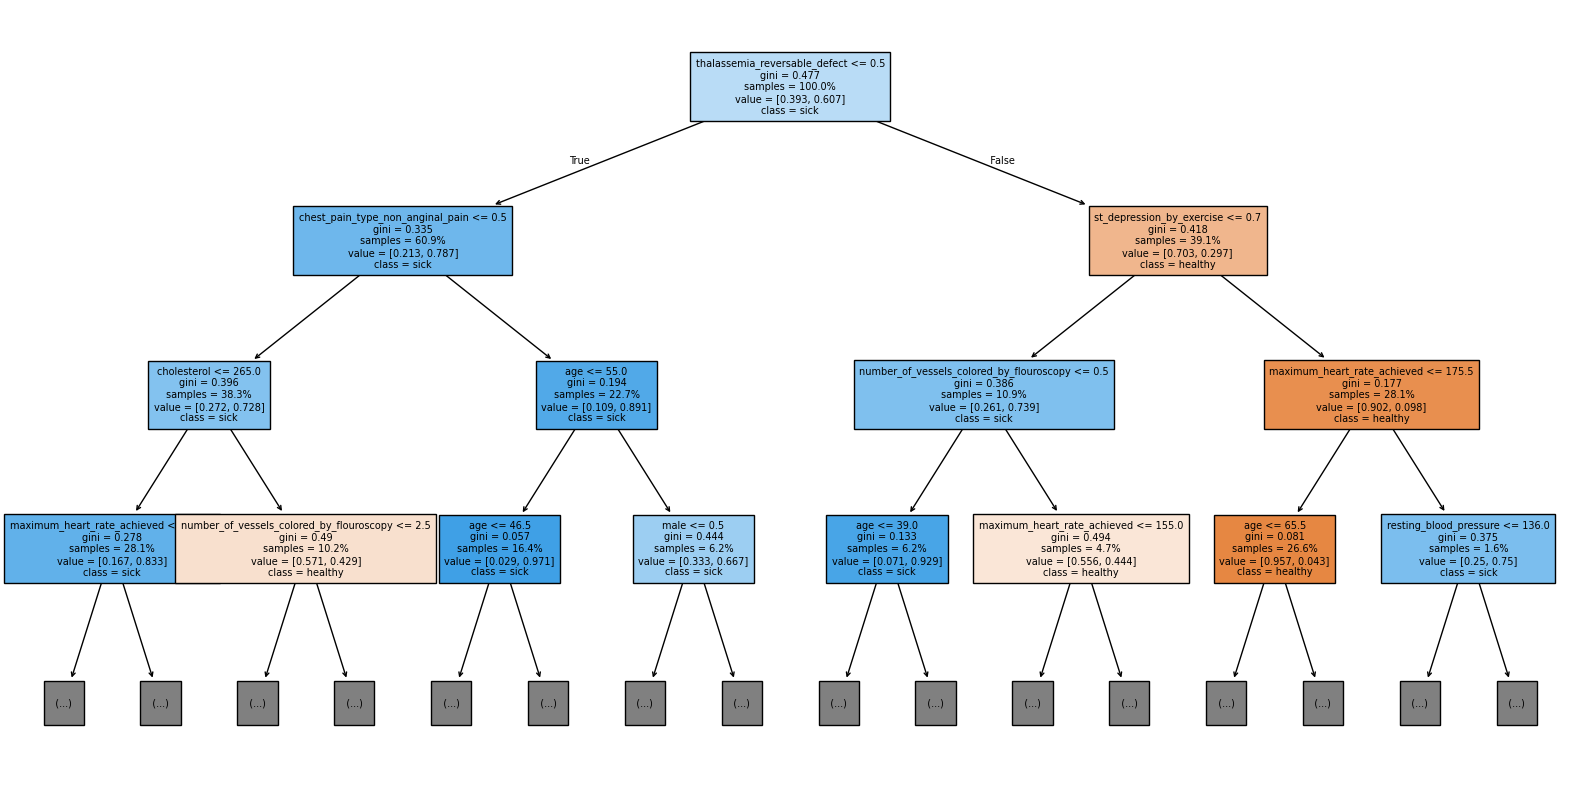

In [ ]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    random_tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = cardiovascular_diseases_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=7, # Establecemos el tamaño de la letra del texto dentro de cada nodo.,
    max_depth=3 # Profundidad máxima del árbol
)
plt.show()

In [ ]:
random_tree = random_forest.estimators_[0]

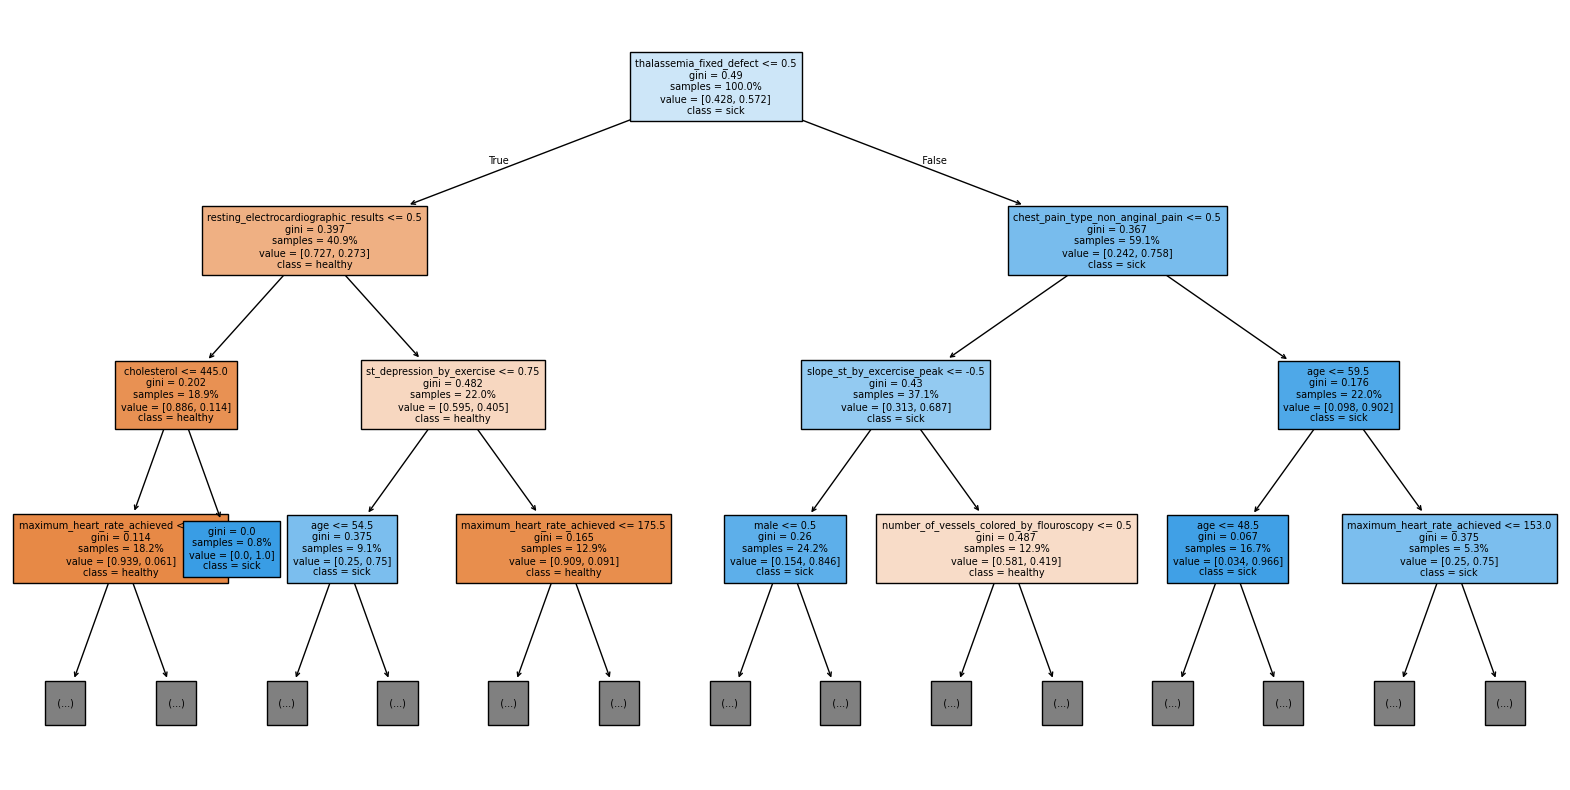

In [ ]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    random_tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = cardiovascular_diseases_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=7, # Establecemos el tamaño de la letra del texto dentro de cada nodo.,
    max_depth=3 # Profundidad máxima del árbol
)
plt.show()

## Boosting

Boosting es la técnica de utilizar un conjunto de estimadores débiles para generar una predicción más robusta.

Cómo estimador débil utilizaremos un perceptrón, pero para ello primero necesitamos escalar nuestras características con `sklearn.preprocessing.RobustScaler()` debido a que este algoritmo es sensible a la escala de las variables.

In [ ]:
# Escalamos las características
scaler = sklearn.preprocessing.RobustScaler()
cardiovascular_diseases_features_train_scaled = scaler.fit_transform(cardiovascular_diseases_features_train)
cardiovascular_diseases_features_test_scaled = scaler.transform(cardiovascular_diseases_features_test)

In [ ]:
perceptron = sklearn.linear_model.Perceptron(random_state = 11, max_iter=10, fit_intercept=False)
perceptron.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

Perceptron(fit_intercept=False, max_iter=10, random_state=11)

Verificamos el rendimiento de nuestro perceptrón único.

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    perceptron.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        47
           1       0.77      0.81      0.79        53

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



Ahora ajustaremos un conjunto de perceptrones con `sklearn.ensemble.AdaBoostClassifier()`.

In [ ]:
boosting = sklearn.ensemble.AdaBoostClassifier( # Istanciamos AdaBoost
    estimator = sklearn.linear_model.Perceptron(random_state = 11, max_iter=10, fit_intercept=False), # Utilizamos un perceptrón como estimador base.
    algorithm = "SAMME", # Utilizamos SAMME como algoritmo de boosting porque perceptrón no implementa el cálculo de probabilidades de predicción.
    n_estimators = 1000, # Nuestro conjunto tendrá 1000 estimadores débiles.
    random_state = 11,
    learning_rate = 0.1
)
boosting.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=Perceptron(fit_intercept=False, max_iter=10,
                                        random_state=11),
                   learning_rate=0.1, n_estimators=1000, random_state=11)

Verificamos que efectivamente mejoramos el rendimiento al utilizar un conjunto de estimadores débiles.

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    boosting.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.85      0.85      0.85        53

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



### Actividad 3

Podemos utilizar boosting con cualquier estimador débil, este sólo debe comportarse mejor que el azar. Ajusta un conjunto de Support Vector Machines con kernel lineal con AdaBoost y verifica que funcione mejor que un estimador único.

In [ ]:
svm = sklearn.svm.SVC(kernel="linear")
svm.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

SVC(kernel='linear')

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    svm.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        47
           1       0.81      0.81      0.81        53

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



In [ ]:
boosting_svm = sklearn.ensemble.AdaBoostClassifier( # Istanciamos AdaBoost
    estimator = sklearn.svm.SVC(kernel="linear"), # Utilizamos un perceptrón como estimador base.
    algorithm = "SAMME", # Utilizamos SAMME como algoritmo de boosting porque perceptrón no implementa el cálculo de probabilidades de predicción.
    n_estimators = 1000, # Nuestro conjunto tendrá 1000 estimadores débiles.
    random_state = 11
)
boosting_svm.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME', estimator=SVC(kernel='linear'),
                   n_estimators=1000, random_state=11)

In [ ]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    boosting_svm.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81        47
           1       0.80      0.92      0.86        53

    accuracy                           0.84       100
   macro avg       0.85      0.83      0.84       100
weighted avg       0.85      0.84      0.84       100

